### Handle imports:

In [19]:
# Move to root directory
import os

notebooks_dir = 'notebooks'
if notebooks_dir in os.path.abspath(os.curdir):
    while not os.path.abspath(os.curdir).endswith('notebooks'):
        print(os.path.abspath(os.curdir))
        os.chdir('..')
    os.chdir('..')  # to get to root

print(os.path.abspath(os.curdir))

/Users/jb_vandeneynde/code/jb-vde/Belfius/llm_esg_kpi/eyalytics


In [5]:
# Get API Key:
from dotenv import load_dotenv
load_dotenv()
if not os.getenv("OPENAI_API_KEY"):
    raise KeyError(
        "You will need an OPENAI_API_KEY to use the LLM models in this notebook."
    )

In [58]:
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain.agents.agent_toolkits import create_python_agent
from langchain.agents import initialize_agent
from langchain.tools.python.tool import PythonREPLTool
from langchain.agents import Tool, ZeroShotAgent
from langchain import OpenAI
from langchain.agents.agent_types import AgentType

In [55]:
db = SQLDatabase.from_uri("sqlite:///data/cwyod/chinook.db")
toolkit = SQLDatabaseToolkit(db=db, llm=OpenAI(temperature=0))

sql_agent = create_sql_agent(
    llm=OpenAI(temperature=0),
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

In [56]:
python_agent = create_python_agent(
    llm=OpenAI(temperature=0, max_tokens=1000),
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

In [72]:
# TODO: Include this somehow to prevent main agent to input sql code in SQL agent

# Standard prefix
prefix = "Fulfill the following request as best you can. You have access to the following tools:"

# Remind the agent of the Data tool, and what types of input it expects
suffix = (
    "Begin! When looking for data, do not write a SQL query. "
    "Pass the relevant portion of the request directly to the SQL tool in its entirety."
    "\n\n"
    "Request: {input}\n"
    "{agent_scratchpad}"
)

In [73]:
agent = initialize_agent(
    tools=[
        Tool(
            name="SQLAgent",
            func=sql_agent.run,
            description="Useful for when you need to answer questions about music store. "
                        "You must not input SQL code in it, but the relevant part of the request. Use this more than the Python tool if the question "
                        "is about the music store.",
        ),
        Tool(
            name="PythonAgent",
            func=python_agent.run,
            description="""Useful to run python commands and for plotting.""",
        ),
    ],
    llm=OpenAI(temperature=0),
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)



> Entering new AgentExecutor chain...
 I need to get the data from the music store and then plot it.

Action: SQLAgent
Action Input: SELECT playlist_name, COUNT(*) FROM songs GROUP BY playlist_name

> Entering new AgentExecutor chain...
Thought: I should check my query before executing it.
Action: sql_db_list_tables
Action Input: 
Observation: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
Thought: I should query the schema of the Playlist and Track tables.
Action: sql_db_schema
Action Input: Playlist, Track
Observation: 
CREATE TABLE "Playlist" (
	"PlaylistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("PlaylistId")
)

/*
3 rows from Playlist table:
PlaylistId	Name
1	Music
2	Movies
3	TV Shows
*/


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT

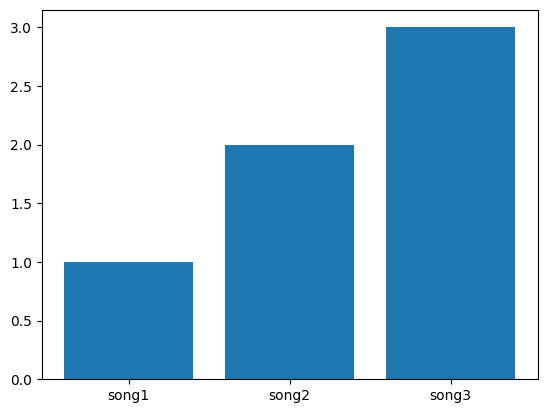

In [74]:
request = """
Show me a bar chart of the number of songs in each playlist. 
"""
response = agent.run(request)
print(response)